### Calculate size of binary caustic (https://arxiv.org/pdf/astro-ph/0505363)
$\cos{\phi_c} = \dfrac{3}{4}(s + s^{-1})\left(1 - \sqrt{1 - \dfrac{32}{9}(s + s^{-1})^{-2}}\right)$ (Equation 10)

$\Delta\xi_c = \dfrac{4q}{(s - s^{-1})^2}$ (Equation 11)

$\Delta\eta_c = \Delta\xi_c \dfrac{(s - s^{-1})^2|\sin^3{\phi_c}|}{(s + s^{-1} - 2\cos{\phi_c})^2}$ (Equation 12)

### Calculate thickness of annulus from difference in positions of major and minor images
$y_{\pm} = \pm \dfrac{1}{2}(\sqrt{u^2+4} \pm u)$

$t = y_{+} - y_{-} = \sqrt{u^2+4}$
<!-- \sqrt{u^2 + 4}$// -->

$u \equiv$ farthest point from CM of caustic

Positions of cusps:

$\xi_{c, 0\pm} \approx \pm \dfrac{q}{(1 \pm s)(1 \pm s^{-1})}$

$\eta_{c, 0\pm} \approx \pm \dfrac{2q|\sin^3{\phi_c}|}{(s + s^{-1} - 2\cos{\phi_c})^2}$

In [5]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import MulensModel as mm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as patches

import sys
sys.path.append('..')

from IRSMicroLensing import IRSCaustics as IRSC

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
lens_att = [
    [0, 0, 0.01, 1],
    [0.2, 0, 0.01, 0.001]
]

lens_att = np.array(lens_att)

L = np.shape(lens_att)[0]
# total_M = np.sum(lens_att[:, 3])

# CM_sum = 0
# for i in range(L):
#     CM_sum += lens_att[i, :2] * lens_att[i, 3]

# lens_CM = CM_sum / total_M

# lens_att[:, :2] = lens_att[:, :2] - lens_CM

lens_CMs = np.zeros(shape=(L, 2))
for i in range(1, L):
    print(i)
    q = lens_att[i, -1]
    s = lens_att[i, 0]

    lens_CMs[i, 0] = q * s / (1 + q)

print(lens_att)
print(lens_CMs)

1
[[0.    0.    0.01  1.   ]
 [0.2   0.    0.01  0.001]]
[[0.        0.       ]
 [0.0001998 0.       ]]


In [29]:
def calc_size_caustic(i, q, s):
    '''
    Calculating the size of the central caustic.
    '''
    cos_phi_c = 3/4 * (s + s**-1) * (1 - np.sqrt(1 - 32/9*(s + s**-1)**-2))
    print('cos(phi_c):', cos_phi_c)
    phi_c = np.arccos(cos_phi_c)
    print('phi_c:', phi_c)

    height = 4*q / (s - s**-1)**2

    width = height * ((s - s**-1)**2 * np.abs(np.sin(phi_c)**3)) / (s + s**-1 - 2 * cos_phi_c)**2

    x_pos = q / ((1 + s)*(1 + s**-1)) - lens_CMs[i+1, 0]
    x_neg = -q / ((1 - s)*(1 - s**-1)) - lens_CMs[i+1, 0]

    print('xi_c,0+:', x_pos)
    print('xi_c,0-:', x_neg)

    y_pos = (2*q * np.abs(np.sin(phi_c)**3)) / (s + s**-1 - 2*cos_phi_c)**2 - lens_CMs[i+1, 1]
    y_neg = -(2*q * np.abs(np.sin(phi_c)**3)) / (s + s**-1 - 2*cos_phi_c)**2 - lens_CMs[i+1, 1]

    return width, height, [x_neg, x_pos, y_pos*np.tan(phi_c - np.pi/2), y_neg, y_pos]

In [30]:
def calc_mm_points(i, lens_att):
    # Finding which index the bigger mass was passed in (primary lens)
    big_mass = np.where(lens_att[:, 3] == np.max(lens_att[:, 3]))[0][0]

    # Secondary lens
    small_mass = int(not big_mass)

    # Defining unit source vector
    uhat = [1, 0]

    # Defining unit binary axis vector (from primary to secondary lens)
    v = [lens_att[small_mass, 0] - lens_att[big_mass, 0], lens_att[small_mass, 1] - lens_att[big_mass, 1]]
    vhat = v / np.linalg.norm(v)

    # Finding counterclockwise angle between binary axis and source trajectory (alpha)
    if vhat[0] > 0 and vhat[1] > 0:
        alpha = np.arctan(vhat[1]/vhat[0])
    elif vhat[0] < 0 and vhat[1] > 0:
        alpha = np.pi + np.arctan(vhat[1]/vhat[0])
    elif vhat[0] < 0 and vhat[1] < 0:
        alpha = np.pi + np.arctan(vhat[1]/vhat[0])
    elif vhat[0] > 0 and vhat[1] < 0:
        alpha = np.arctan(vhat[1]/vhat[0])
    elif vhat[0] > 0 and vhat[1] == 0:
        alpha = 0
    elif vhat[0] == 0 and vhat[1] > 0:
        alpha = np.pi/2
    elif vhat[0] < 0 and vhat[1] == 0:
        alpha = np.pi
    elif vhat[0] == 0 and vhat[1] < 0:
        alpha = -np.pi/2

    # Calculating distance between lenses (s)
    s = np.linalg.norm(v)

    # Calculating mass ratio between lenses (q)
    q = lens_att[small_mass, 3] / lens_att[big_mass, 3]

    # Initializing MulensModel Caustics class
    model = mm.Caustics(q=q, s=s)

    # Initializing parameter dictionary
    param_dict = {'q': q, 's': s, 'alpha': alpha}

    # Retrieving x and y points of caustics
    caustic_points = np.array(model.get_caustics(n_points=5000)).transpose()

    # Creating rotation matrix (to rotate caustic points into correct binary axis)
    cos, sin = np.cos(alpha), np.sin(alpha)
    Rot = np.array([[cos, -sin], [sin, cos]])

    # Initializing array of rotated caustic points (2x5000)
    rotated_caustic_points = np.zeros(shape=np.shape(caustic_points))

    # Calculating dot product of rotation matrix and each position calculated by MulensModel
    for ii, pos in enumerate(caustic_points):
        rotated_caustic_points[ii] = np.dot(Rot, pos)

    # Extracting array of x and array of y values
    mm_x = rotated_caustic_points.transpose()[0]
    mm_y = rotated_caustic_points.transpose()[1]

    width, height, cusp_points = calc_size_caustic(i, q, s)

    return mm_x, mm_y, alpha, width, height, cusp_points

In [31]:
mm_x_list = np.zeros((5000, len(lens_att) - 1))
mm_y_list = np.zeros((5000, len(lens_att) - 1))
alphas = np.zeros(len(lens_att) - 1)
rectangle_list = []
cusp_points_x_list = []
cusp_points_y_list = []

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

for i, lens in enumerate(lens_att[1:]):
    two_lenses = np.array([lens_att[0], lens])
    mm_x_list[:, i], mm_y_list[:, i], alphas[i], width, height, cusp_points = calc_mm_points(i, two_lenses)
    
    cusp_points_x_list.append([cusp_points[0], cusp_points[1], cusp_points[2], cusp_points[2]])
    cusp_points_y_list.append([0, 0, cusp_points[3], cusp_points[4]])

    bounding_box = patches.Rectangle((-width/2, -height/2), width, height, facecolor='none', edgecolor=default_colors[i], angle=np.rad2deg(alphas[i]), rotation_point=(0, 0))

    rectangle_list.append(bounding_box)

for i, rectangle in enumerate(rectangle_list):
    ax.scatter(mm_x_list[:, i], mm_y_list[:, i], s=0.01, alpha=1, c=default_colors[i])
    ax.scatter(cusp_points_x_list[i], cusp_points_y_list[i], s=10, c='red')
    ax.add_patch(rectangle)

bound = 0.005
ax.set_xlim(-bound, bound)
ax.set_ylim(-bound, bound)
ax.set_aspect('equal')

plt.show()

cos(phi_c): 0.2654436309227506
phi_c: 1.302132295873299
xi_c,0+: -6.091131091131091e-05
xi_c,0-: 0.00011269980019980018


In [2]:
def ang_width_thickness_calculator(lens_att: list):
    '''
    Calculates the angular width of sampling region and thickness of shooting region using Equations 8-10 in https://arxiv.org/pdf/astro-ph/0505363.

    Parameters
    ----------
    lens_att : list
        Passed through via passed_params dict

    Returns
    -------
    ang_width : float
        Angular width of ray sampling region
    thickness : float
        Thickness of annulus shooting region
    '''
    lens_att = np.array(lens_att)
    
    # Number of lens objects
    L = np.shape(lens_att)[0]

    # Initializing maximum distance from origin list
    max_dist_rot = []
    max_dist = []
    points = np.zeros(shape=(L-1, 4, 2))

    # Initializing padding
    padding = 2

    # Calculating the center of masses of each individual star-planet combination
    lens_CMs_rot = np.zeros(shape=(L-1, 2))
    
    for i, lens in enumerate(lens_att[1:]):
        two_lenses = np.array([lens_att[0], lens])

        # Finding which index the bigger mass was passed in (primary lens)
        big_mass = np.where(two_lenses[:, 3] == np.max(two_lenses[:, 3]))[0][0]

        # Secondary lens
        small_mass = int(not big_mass)

        # Defining unit source vector
        uhat = [1, 0]

        # Defining unit binary axis vector (from primary to secondary lens)
        v = [two_lenses[small_mass, 0] - two_lenses[big_mass, 0], two_lenses[small_mass, 1] - two_lenses[big_mass, 1]]
        vhat = v / np.linalg.norm(v)

        # Finding counterclockwise angle between binary axis and source trajectory (alpha)
        if vhat[0] > 0 and vhat[1] > 0:
            alpha = np.arctan(vhat[1]/vhat[0])
        elif vhat[0] < 0 and vhat[1] > 0:
            alpha = np.pi + np.arctan(vhat[1]/vhat[0])
        elif vhat[0] < 0 and vhat[1] < 0:
            alpha = np.pi + np.arctan(vhat[1]/vhat[0])
        elif vhat[0] > 0 and vhat[1] < 0:
            alpha = np.arctan(vhat[1]/vhat[0])
        elif vhat[0] > 0 and vhat[1] == 0:
            alpha = 0
        elif vhat[0] == 0 and vhat[1] > 0:
            alpha = np.pi/2
        elif vhat[0] < 0 and vhat[1] == 0:
            alpha = np.pi
        elif vhat[0] == 0 and vhat[1] < 0:
            alpha = -np.pi/2

        # Calculating distance between lenses (s)
        s = np.linalg.norm(v)

        # Calculating mass ratio between lenses (q)
        q = two_lenses[small_mass, 3] / two_lenses[big_mass, 3]

        # Calculating center of mass in binary axis
        lens_CMs_rot[i, 0] = q*s / (1 + q)

        # Creating rotation matrix
        cos, sin = np.cos(alpha), np.sin(alpha)
        Rot = np.array([[cos, -sin], [sin, cos]])

        # Finding cos(phi_c) - Equation 10
        cos_phi_c = 3/4 * (s + s**-1) * (1 - np.sqrt(1 - 32/9*(s + s**-1)**-2))

        # Finding phi_c through arccos
        phi_c = np.arccos(cos_phi_c)

        # Finding positive x and negative x positions - Equation 8
        x_pos_rot = q / ((1 + s)*(1 + s**-1)) - lens_CMs_rot[i, 0]
        x_neg_rot = -q / ((1 - s)*(1 - s**-1)) - lens_CMs_rot[i, 0]

        # Finding positive y and negative y positions - Equation 9
        y_pos_rot = (2*q * np.abs(np.sin(phi_c)**3)) / (s + s**-1 - 2*cos_phi_c)**2 - lens_CMs_rot[i, 1]
        y_neg_rot = -(2*q * np.abs(np.sin(phi_c)**3)) / (s + s**-1 - 2*cos_phi_c)**2 - lens_CMs_rot[i, 1]

        # Storing the maximum distance from the origin of the caustic
        max_dist_rot.append(np.max(np.abs(np.array([x_pos_rot, x_neg_rot, y_pos_rot, y_neg_rot]))))

        # Rotating bounding points back from binary axis to inertial axis
        x_pos = np.dot(Rot, np.array([x_pos_rot, 0]))
        x_neg = np.dot(Rot, np.array([x_neg_rot, 0]))

        y_pos = np.dot(Rot, np.array([0, y_pos_rot]))
        y_neg = np.dot(Rot, np.array([0, y_neg_rot]))

        # Finding maximum distance from the origin and storing it
        points[i, :, :] = np.array([x_pos, x_neg, y_pos, y_neg])
        max_dist.append(np.max(np.abs(points[i, :, :])))

    # Now finding the maximum of the list of maximum distances from the origin of each caustic with a padding
    ang_width = 2*max(max_dist) * padding

    u = ang_width / np.sqrt(2)

    # Calculating thickness from maximum distance from origin
    # thickness = 2*max(max_dist_rot) * padding

    y_plus = 0.5 * (u + np.sqrt(u**2 + 4))
    y_minus = 0.5 * (u - np.sqrt(u**2 + 4))

    thickness = y_plus + y_minus

    return ang_width, thickness, (y_plus, y_minus), points

In [3]:
lens_att = [
    [0, 0, 0.01, 1],
    [0.8, 0, 0.01, 0.001]
]

ang_width, thickness, (y_plus, y_minus), points = ang_width_thickness_calculator(lens_att)

print(y_plus, y_minus)
print(ang_width)
print(thickness)

print(1 - thickness/2, 1 + thickness/2)

1.0275226333941263 -0.9732145721177808
0.07680319680319682
0.054308061276345465
0.9728459693618272 1.0271540306381728


{'pixels': 1000, 'ang_width': np.float64(0.07680319680319682), 'lens_att': [[0, 0, 0.01, 1], [0.8, 0, 0.01, 0.001]], 'thickness': np.float64(0.059738867403980045), 'num_r': 20000, 'num_theta': 10000, 'ang_res': np.float64(7.680319680319682e-05), 'pixel_density': np.float64(13020.29136316337), 'dr': np.float64(2.986943370199002e-06), 'dtheta': 0.036, 'num_rays': 200000000}
Creating mesh grid: 0.439 seconds
1 0.5666208267211914
2 2.450683832168579
3 0.00038623809814453125
4 2.6702880859375e-05
5 1.8835067749023438e-05
6 0.0005819797515869141
(2, 1, 1)
(2, 1, 1)
7 5.400143146514893
8 18.73355531692505
9 0.0015740394592285156
10 0.0005800724029541016
Calculating source pixels: 28.214 seconds
Calculating indices of translated pixel after deflection: 3.774 seconds
Calculating translated pixels: 8.712 seconds
Finding pixel repetitions and counts: 1.952 seconds
Incrementing pixel magnifications based on counts and repetitions: 0.49 seconds
Plotting magnification map: 0.165 seconds
------------

/Users/saividyud/Documents/GitHub/NBLens/tests/../IRSMicroLensing/IRSCaustics.py:512: RuntimeWarning: divide by zero encountered in log10
  self.magnifications_log = np.log10(self.magnifications)


1.030315425782361 -0.970576558378381


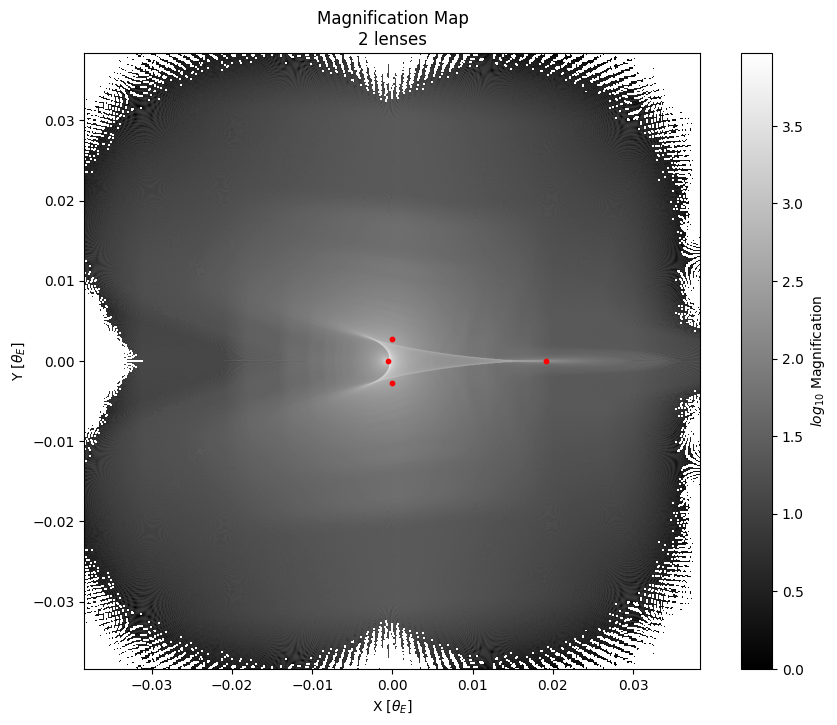

In [14]:
num_theta = 10000
num_r = 2 * num_theta

binary_param_dict = {'pixels': 1000, 'ang_width': 'auto', 'lens_att': lens_att, 'thickness': 'auto', 'num_r': num_r, 'num_theta': num_theta}

binary_mag_map = IRSC.IRSCaustics(annulus_param_dict=binary_param_dict)

print(binary_mag_map.param_dict)
binary_magnifications = binary_mag_map.plot(show_lenses=False, show_plot=True, cm_offset=[0, 0], show_dev=False, save_plot=False)

print(binary_mag_map.y_plus, binary_mag_map.y_minus)

for caustic in binary_mag_map.caustic_cusps:
    binary_mag_map.ax_c.scatter(caustic[:, 0], caustic[:, 1], s=10, c='red')

plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

img = ax.imshow(binary_magnifications)
plt.colorbar(img, ax=ax, label='Magnification')

plt.show()